## Reference mapping with scvi-tools

This tutorial covers the usage of the [scArches method](https://www.biorxiv.org/content/10.1101/2020.07.16.205997v1) with SCVI, SCANVI, and TOTALVI.

This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query). The goal is to analyze these samples in the context of the reference, by mapping the query cells to the same reference latent space. This workflow may also be used in the [scarches](https://scarches.readthedocs.io/) package, but here we demonstrate using only scvi-tools.

### Imports and scvi-tools installation (colab)

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [2]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Last run with scvi-tools version: 1.0.3


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

### Reference mapping with SCVI

Here we use the pancreas dataset described in the [scIB](https://github.com/theislab/scib) manuscript, that is also widely used to benchmark integration methods.

In [5]:
pancreas_adata_path = os.path.join(save_dir.name, "pancreas.h5ad")

pancreas_adata = sc.read(
    pancreas_adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539828",
)
pancreas_adata

  0%|          | 0.00/301M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [6]:
pancreas_adata.obs["tech"].value_counts()

tech
inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: count, dtype: int64

We consider the SS2 and CelSeq2 samples as query, and all the others as reference.

In [8]:
query_mask = np.array([s in ["smartseq2", "celseq2"] for s in pancreas_adata.obs["tech"]])

pancreas_ref = pancreas_adata[~query_mask].copy()
pancreas_query = pancreas_adata[query_mask].copy()

We run highly variable gene selection on the reference data and use these same genes for the query data.

In [10]:
sc.pp.highly_variable_genes(pancreas_ref, n_top_genes=2000, batch_key="tech", subset=True)

pancreas_query = pancreas_query[:, pancreas_ref.var_names].copy()

#### Train reference

We train the reference using the standard SCVI workflow, except we add a few non-default parameters that were identified to work well with scArches. 
It is essential to encode covariates here as this allows scArches to map new batches in the encoder to the existing data and thereby provides batch integration. 

In [11]:
scvi.model.SCVI.setup_anndata(pancreas_ref, batch_key="tech", layer="counts")

/home/martin/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [12]:
scvi_ref = scvi.model.SCVI(
    pancreas_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)
scvi_ref.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/martin/dev/scvi-tools/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/martin/dev/scvi-tools/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:00<06:28,  1.03it/s, v_num=1, train_loss_step=971, train_loss_epoch=1.3e+3]

/home/martin/dev/scvi-tools/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|██████████| 400/400 [03:10<00:00,  2.08it/s, v_num=1, train_loss_step=696, train_loss_epoch=787]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:10<00:00,  2.10it/s, v_num=1, train_loss_step=696, train_loss_epoch=787]


Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [15]:
SCVI_LATENT_KEY = "X_scVI"

pancreas_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(pancreas_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(pancreas_ref)
sc.tl.umap(pancreas_ref)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/bin/mambaforge/envs/scvi-tools-

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


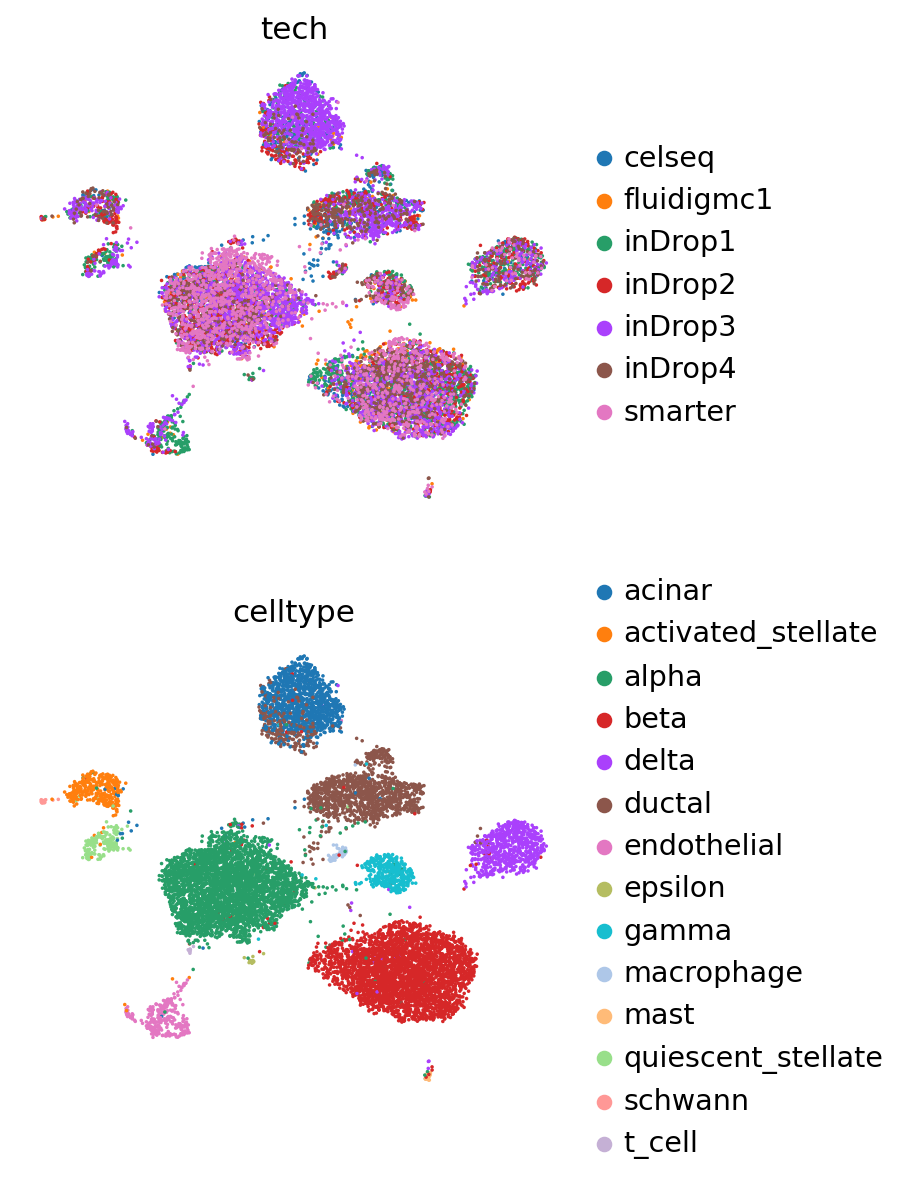

In [16]:
sc.pl.umap(
    pancreas_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

#### Update with query

We can load a new model with the query data either using

1. The saved reference model
1. The instance of the reference model

In [17]:
scvi_ref_path = os.path.join(save_dir.name, "pancreas_scvi_ref")
scvi_ref.save(scvi_ref_path, overwrite=True)

First we validate that our query data is ready to be loaded into the reference model. Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness. In the case of this tutorial, nothing happens as the query data is already "correct".

In [18]:
# both are valid
scvi.model.SCVI.prepare_query_anndata(pancreas_query, scvi_ref_path)
scvi.model.SCVI.prepare_query_anndata(pancreas_query, scvi_ref)

INFO     File /tmp/tmp2qkhcse5/pancreas_scvi_ref/model.pt already downloaded                                       
INFO     Found 100.0% reference vars in query data.                                                                
INFO     Found 100.0% reference vars in query data.                                                                


Now we create the new query model instance.

In [19]:
# both are valid
scvi_query = scvi.model.SCVI.load_query_data(
    pancreas_query,
    scvi_ref_path,
)
scvi_query = scvi.model.SCVI.load_query_data(
    pancreas_query,
    scvi_ref,
)

INFO     File /tmp/tmp2qkhcse5/pancreas_scvi_ref/model.pt already downloaded                                       


/home/martin/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/martin/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


This is a typical `SCVI` object, and after training, can be used in any defined way.

For training the query data, we recommend using a `weight_decay` of 0.0. This ensures the latent representation of the reference cells will remain exactly the same if passing them through this new query model.

In [20]:
scvi_query.train(max_epochs=200, plan_kwargs={"weight_decay": 0.0})
pancreas_query.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/200:   0%|          | 1/200 [00:00<00:37,  5.25it/s, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=1.94e+3]

/home/martin/dev/scvi-tools/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/martin/dev/scvi-tools/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/200:   0%|          | 1/200 [00:00<00:37,  5.25it/s, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=1.94e+3]

/home/martin/dev/scvi-tools/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/200:   2%|▏         | 3/200 [00:00<00:37,  5.26it/s, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.88e+3]

Epoch 200/200: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.75e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.75e+3]


In [21]:
sc.pp.neighbors(pancreas_query, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(pancreas_query)
sc.tl.umap(pancreas_query)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


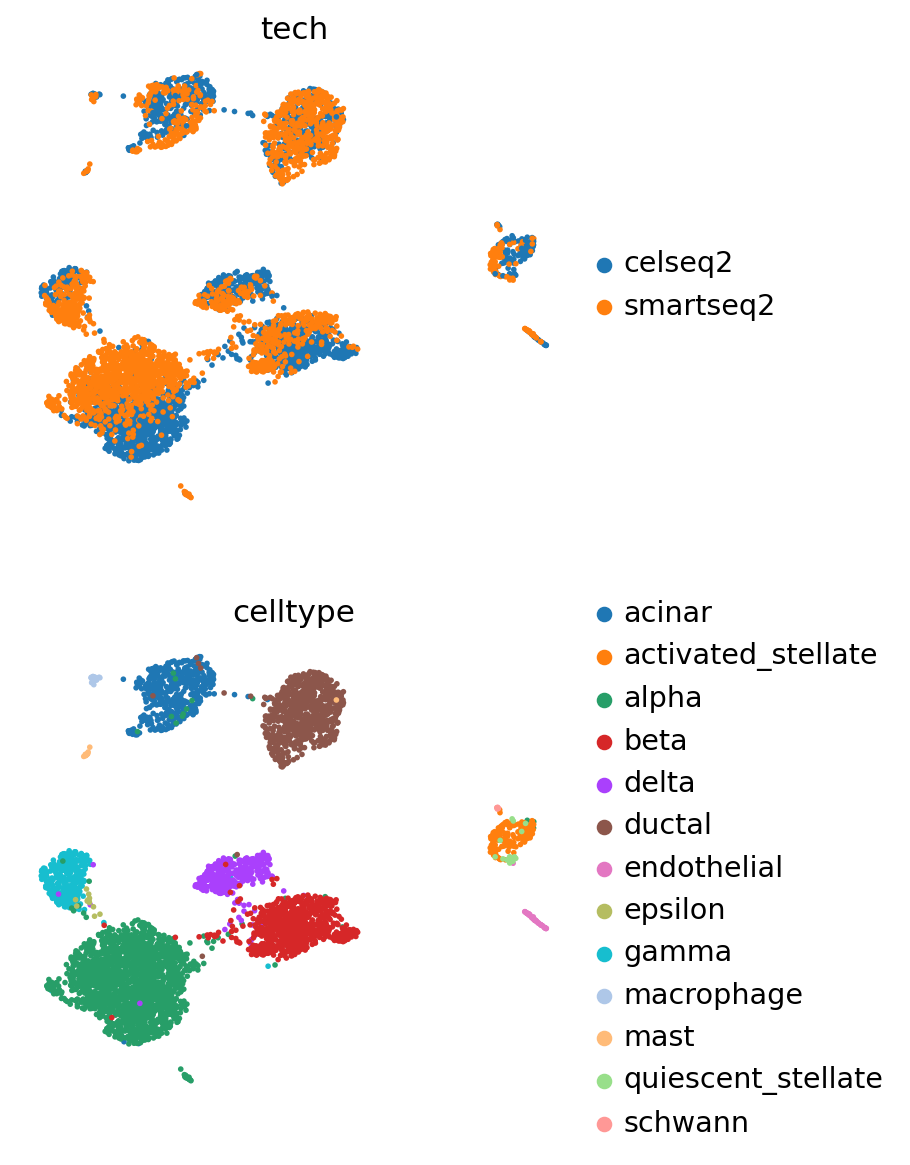

In [22]:
sc.pl.umap(
    pancreas_query,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

#### Visualize reference and query

In [23]:
pancreas_full = anndata.concat([pancreas_query, pancreas_ref])
pancreas_full

AnnData object with n_obs × n_vars = 16382 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'

The concatenated object has the latent representations of both reference and query, but we are also able to reobtain these values using the query model.

In [24]:
pancreas_full.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation(pancreas_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/martin/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [25]:
sc.pp.neighbors(pancreas_full, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(pancreas_full)
sc.tl.umap(pancreas_full)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


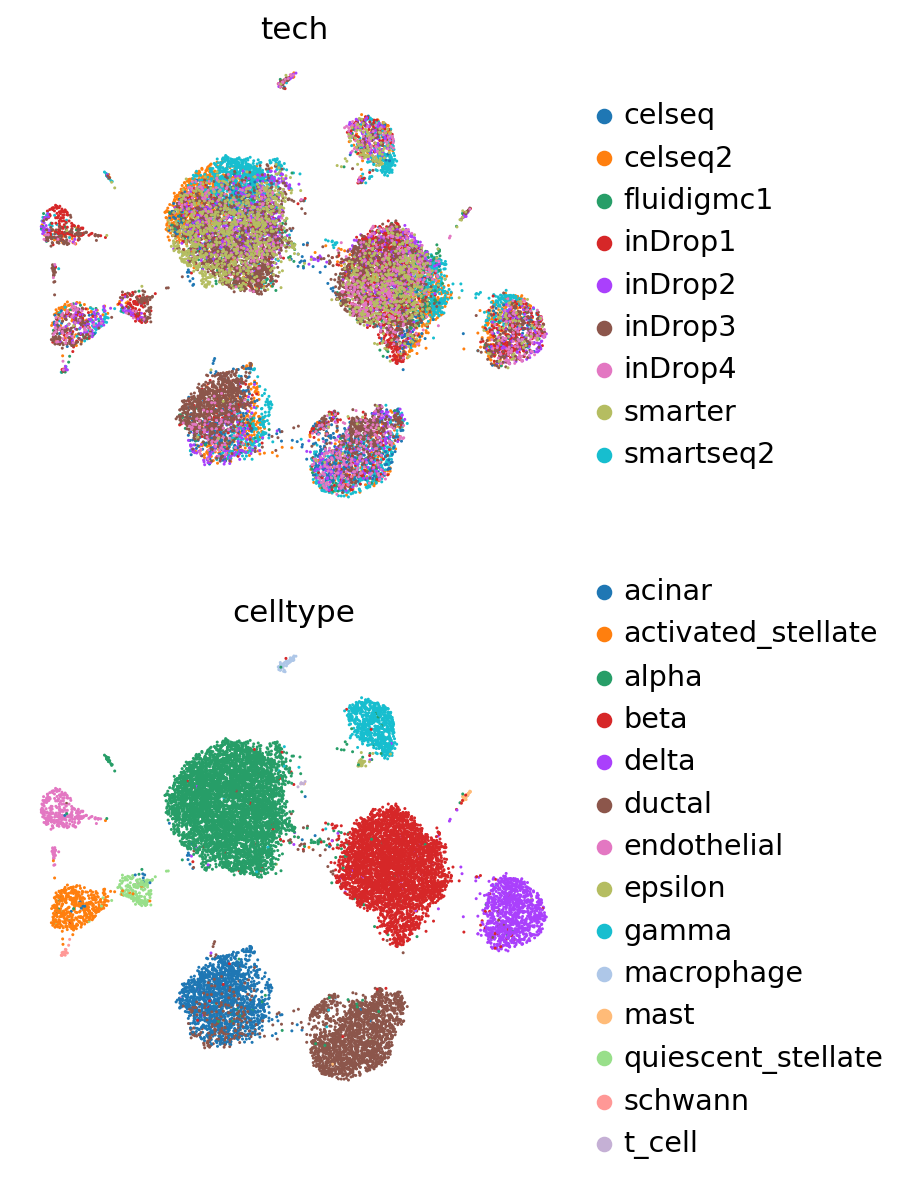

In [26]:
sc.pl.umap(
    pancreas_full,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

### Reference mapping with SCANVI

We'll use the same Pancreas dataset, this time we set it up such that we register that the dataset has labels.

The advantage of SCANVI is that we'll be able to predict the cell type labels of the query dataset. In the case of SCVI, a separate classifier (e.g., nearest-neighbor, random forest, etc.) would have to be trained on the reference latent space.

#### Train reference

`SCANVI` tends to perform better in situations where it has been initialized using a pre-trained `SCVI` model. In this case, we will use `vae_ref` that we have already trained above. In other words, a typical `SCANVI` workflow will be:

```python
scvi_model = SCVI(adata_ref, **arches_params)
scvi_model.train()
scanvi_model = SCANVI.from_scvi_model(scvi_model, unlabeled_category="Unknown")
scanvi_model.train()
```

`SCANVI.from_scvi_model` will also run `setup_anndata`. It will use the `batch_key` and `layer` used with `SCVI`, but here we add the `labels_key`.

For this part of the tutorial, we will create a new labels key in the reference anndata object to reflect the common scenario of having no labels for the query data.

In [27]:
SCANVI_LABELS_KEY = "labels_scanvi"

pancreas_ref.obs[SCANVI_LABELS_KEY] = pancreas_ref.obs["celltype"].values

Applying this workflow in the context of this tutorial:

In [28]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
scanvi_ref = scvi.model.SCANVI.from_scvi_model(
    scvi_ref,
    unlabeled_category="Unknown",
    labels_key=SCANVI_LABELS_KEY,
)

/home/martin/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [29]:
scanvi_ref.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/home/martin/dev/scvi-tools/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/martin/dev/scvi-tools/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/20:   5%|▌         | 1/20 [00:01<00:20,  1.08s/it, v_num=1, train_loss_step=969, train_loss_epoch=896]

/home/martin/dev/scvi-tools/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 20/20: 100%|██████████| 20/20 [00:21<00:00,  1.11s/it, v_num=1, train_loss_step=811, train_loss_epoch=864]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it, v_num=1, train_loss_step=811, train_loss_epoch=864]


In [30]:
SCANVI_LATENT_KEY = "X_scANVI"

pancreas_ref.obsm[SCANVI_LATENT_KEY] = scanvi_ref.get_latent_representation()
sc.pp.neighbors(pancreas_ref, use_rep=SCANVI_LATENT_KEY)
sc.tl.leiden(pancreas_ref)
sc.tl.umap(pancreas_ref)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


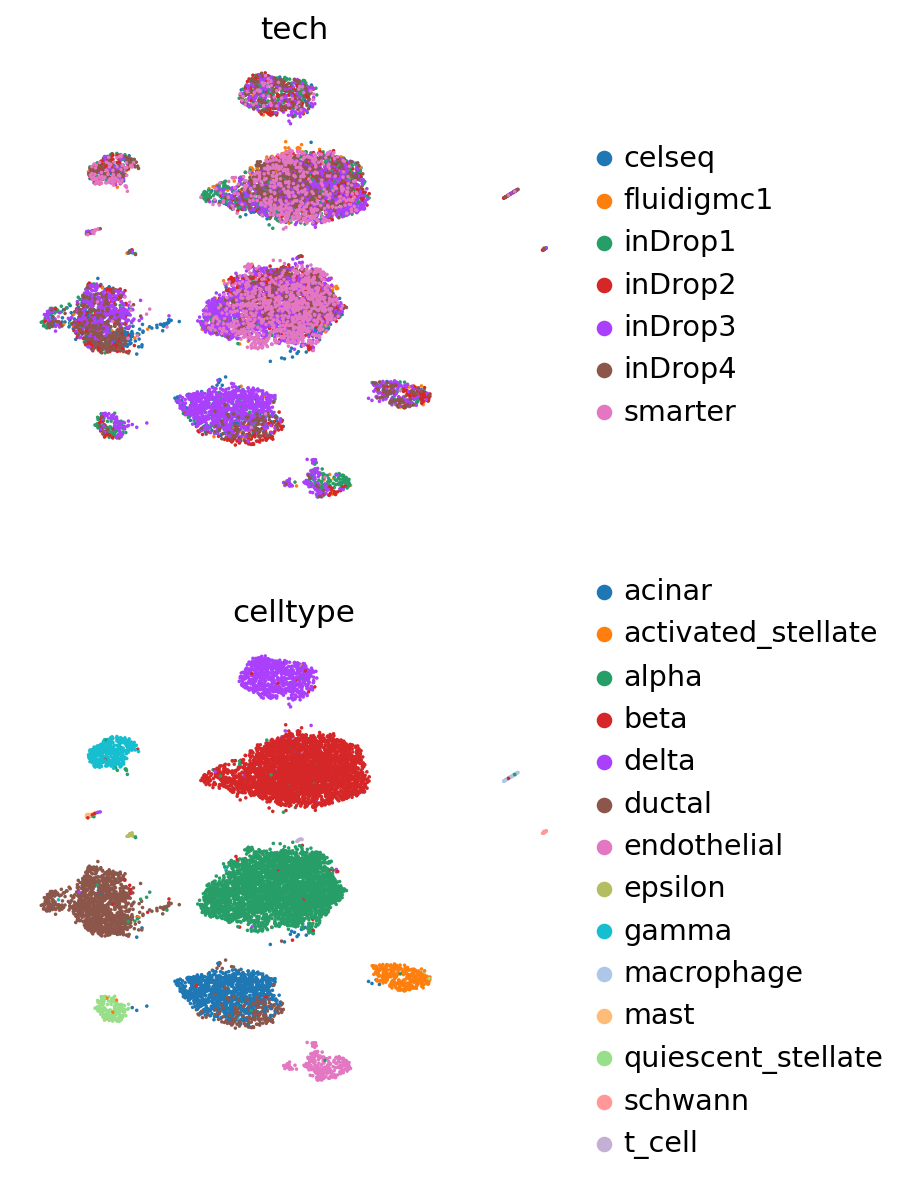

In [31]:
sc.pl.umap(
    pancreas_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

#### Update with query

In [32]:
scanvi_ref_path = os.path.join(save_dir.name, "pancreas_scanvi_ref")
scanvi_ref.save(scanvi_ref_path, overwrite=True)

In [33]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(pancreas_query, scanvi_ref_path)

INFO     File /tmp/tmp2qkhcse5/pancreas_scanvi_ref/model.pt already downloaded                                     
INFO     Found 100.0% reference vars in query data.                                                                


Notice that `adata_query.obs["labels_scanvi"]` does not exist. The `load_query_data` method detects this and fills it in `adata_query` with the unlabeled category (here `"Unknown"`).

In [34]:
scanvi_query = scvi.model.SCANVI.load_query_data(pancreas_query, scanvi_ref_path)

INFO     File /tmp/tmp2qkhcse5/pancreas_scanvi_ref/model.pt already downloaded                                     


/home/martin/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/martin/dev/scvi-tools/scvi/data/_manager.py:212: UserWarning: Missing labels key labels_scanvi. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [35]:
scanvi_query.train(
    max_epochs=100,
    plan_kwargs={"weight_decay": 0.0},
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/home/martin/dev/scvi-tools/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/martin/dev/scvi-tools/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:00<00:30,  3.21it/s, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.95e+3]

/home/martin/dev/scvi-tools/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 11/100:  10%|█         | 10/100 [00:03<00:29,  3.05it/s, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.81e+3]

/home/martin/dev/scvi-tools/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [00:31<00:00,  3.02it/s, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.75e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.75e+3]


In [36]:
SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

pancreas_query.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
pancreas_query.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

Text(0, 0.5, 'Observed')

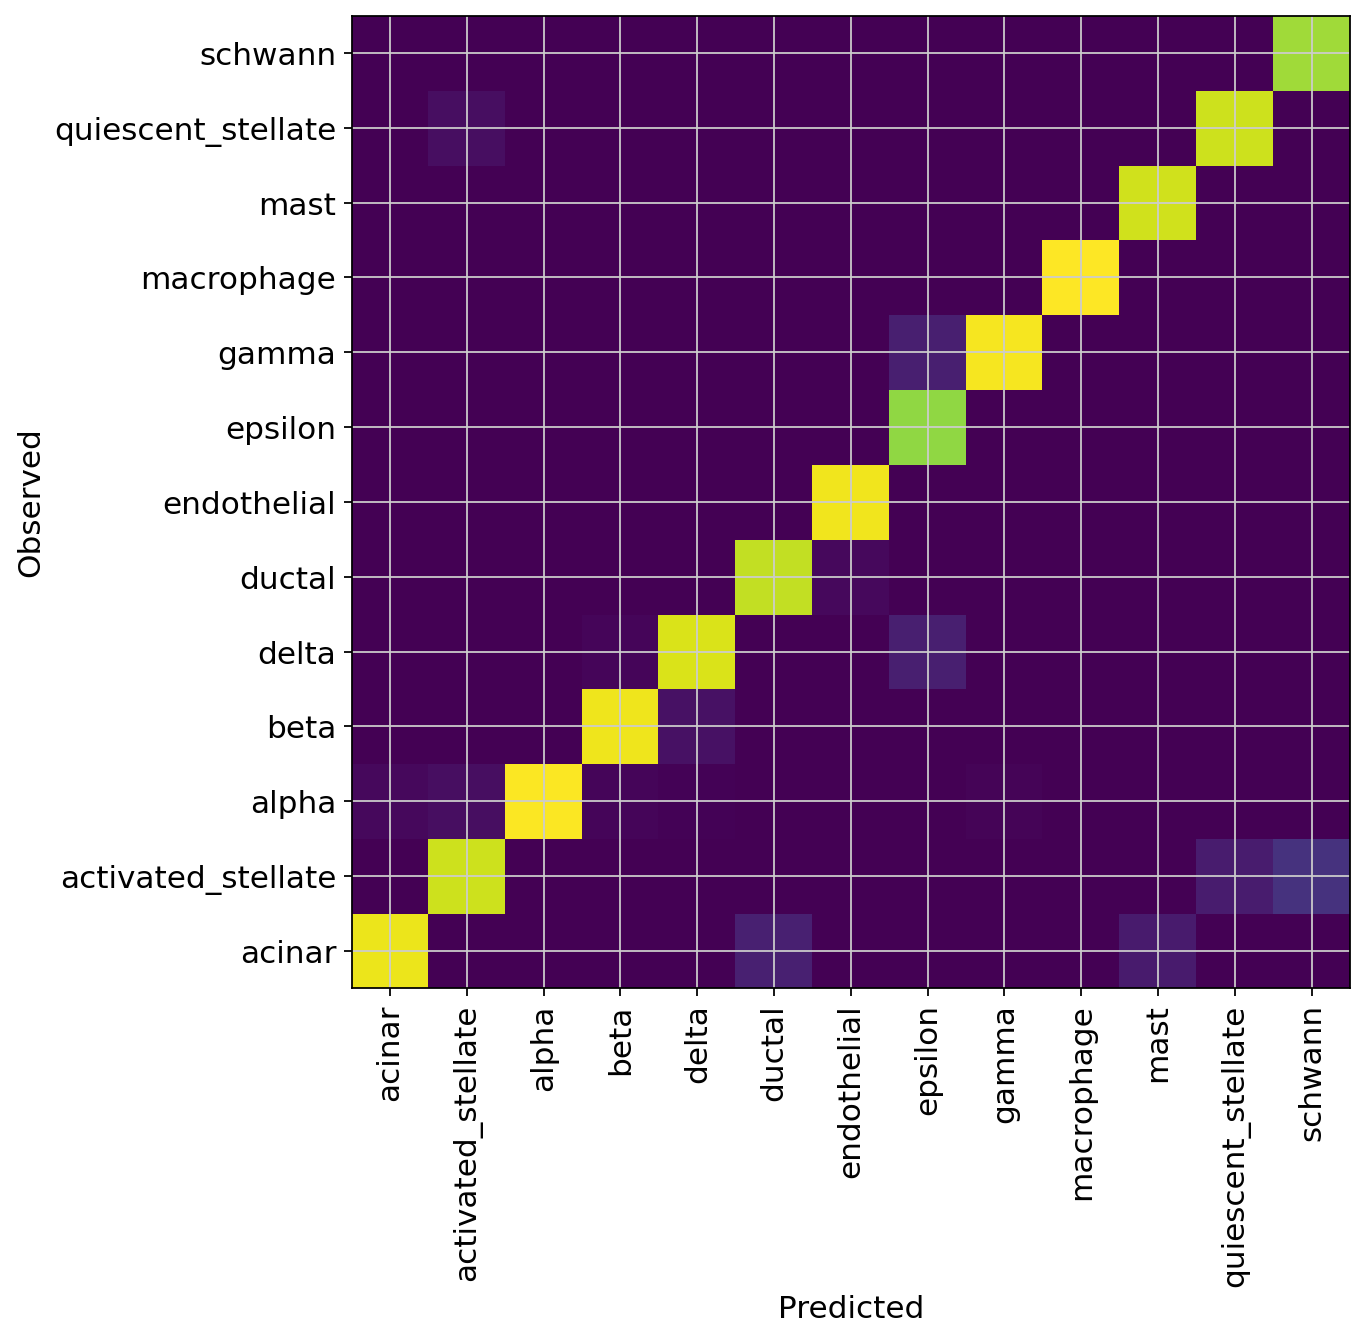

In [37]:
df = pancreas_query.obs.groupby(["celltype", SCANVI_PREDICTIONS_KEY]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

#### Analyze reference and query

In [38]:
pancreas_full = anndata.concat([pancreas_query, pancreas_ref], label="batch")
pancreas_full

AnnData object with n_obs × n_vars = 16382 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden', 'labels_scanvi', 'batch'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    layers: 'counts'

This just makes a column in the anndata corresponding to if the data come from the reference or query sets.

In [39]:
pancreas_full.obs["batch"] = pancreas_full.obs["batch"].cat.rename_categories(
    ["Query", "Reference"]
)

In [40]:
full_predictions = scanvi_query.predict(pancreas_full)
print(f"Acc: {np.mean(full_predictions == pancreas_full.obs['celltype'])}")

pancreas_full.obs[SCANVI_PREDICTIONS_KEY] = full_predictions

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/martin/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Acc: 0.9717372726162862


In [41]:
sc.pp.neighbors(pancreas_full, use_rep=SCANVI_LATENT_KEY)
sc.tl.leiden(pancreas_full)
sc.tl.umap(pancreas_full)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


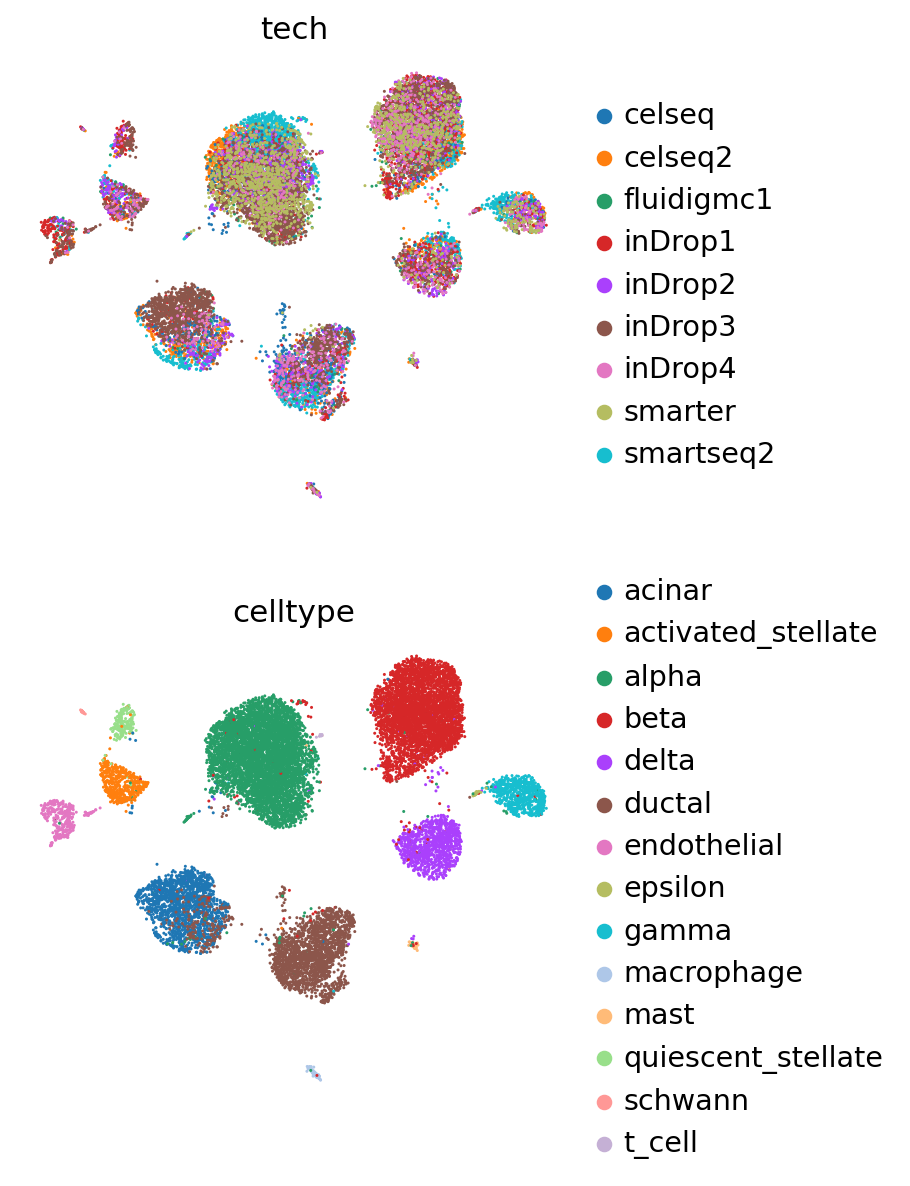

In [42]:
sc.pl.umap(
    pancreas_full,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


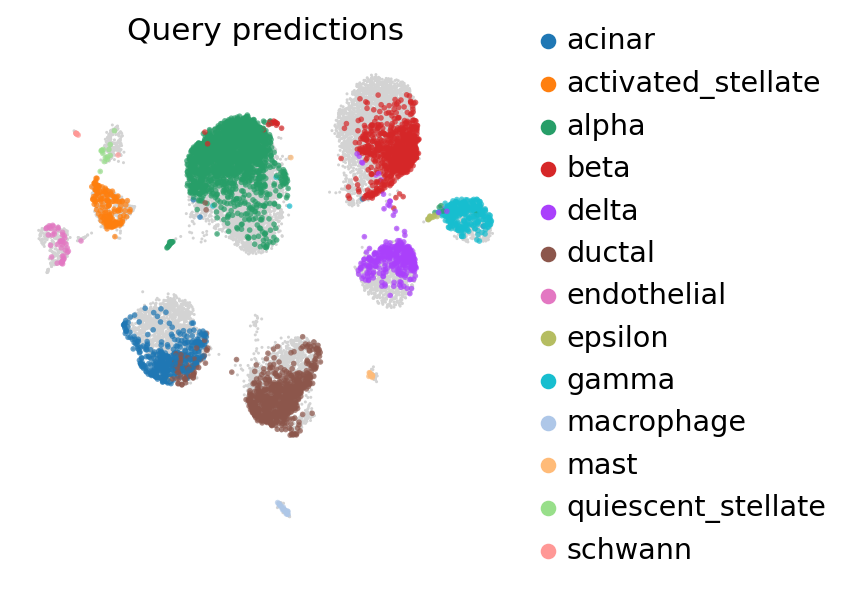

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


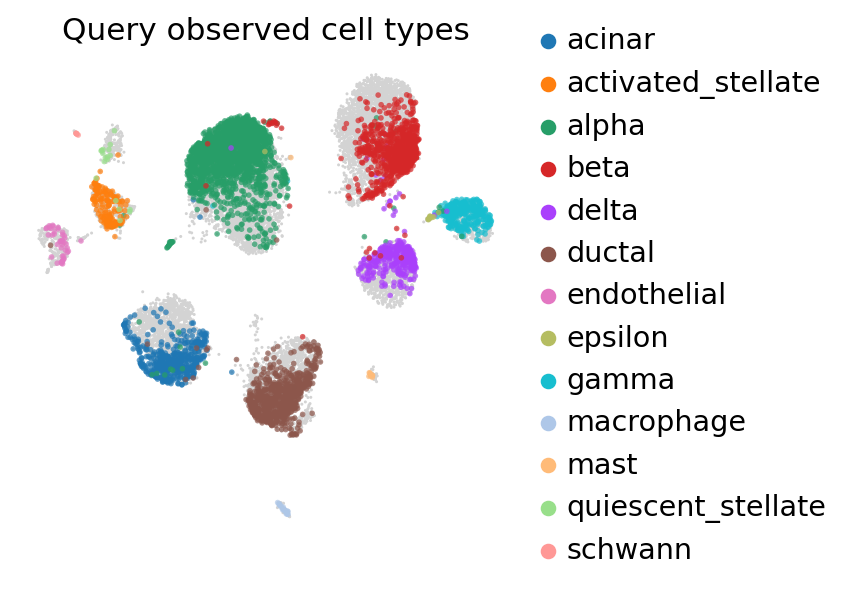

In [43]:
ax = sc.pl.umap(
    pancreas_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    pancreas_full[: pancreas_query.n_obs],
    color=[SCANVI_PREDICTIONS_KEY],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    pancreas_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    pancreas_full[: pancreas_query.n_obs],
    color=["celltype"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)

### Reference mapping with TOTALVI

This workflow works very similarly for TOTALVI. Here we demonstrate how to build a CITE-seq reference and use scRNA-seq only data as the query.

#### Assemble data

For totalVI, we will treat two CITE-seq PBMC datasets from 10X Genomics as the reference. These datasets were already filtered for outliers like doublets, as described in the totalVI manuscript. There are 14 proteins in the reference.

In [44]:
pbmc_ref = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir.name)

INFO     Downloading file at /tmp/tmp2qkhcse5/pbmc_10k_protein_v3.h5ad                                             
Downloading...: 24938it [00:00, 99295.94it/s]                              
INFO     Downloading file at /tmp/tmp2qkhcse5/pbmc_5k_protein_v3.h5ad                                              
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 89430.22it/s]


/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In general, there will be some necessary data wrangling. For example, we need to provide totalVI with some protein data -- and when it's all zeros, totalVI identifies that the protein data is missing in this "batch".

It could have also been the case that only some of the protein data was missing, in which case we would add zeros for each of the missing proteins.

In [45]:
pbmc_query = scvi.data.dataset_10x("pbmc_10k_v3", save_path=save_dir.name)
pbmc_query.obs["batch"] = "PBMC 10k (RNA only)"
# put matrix of zeros for protein expression (considered missing)
pro_exp = pbmc_ref.obsm["protein_expression"]
data = np.zeros((pbmc_query.n_obs, pro_exp.shape[1]))
pbmc_query.obsm["protein_expression"] = pd.DataFrame(
    columns=pro_exp.columns, index=pbmc_query.obs_names, data=data
)

INFO     Downloading file at /tmp/tmp2qkhcse5/pbmc_10k_v3/filtered_feature_bc_matrix.h5                            
Downloading...: 37492it [00:02, 15069.46it/s]                             


/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We do some light QC filtering on the query dataset (doublets, mitochondrial, etc.)

In [46]:
scrub = scr.Scrublet(pbmc_query.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
pbmc_query = pbmc_query[~predicted_doublets].copy()

pbmc_query.var["mt"] = pbmc_query.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pbmc_query, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
pbmc_query = pbmc_query[pbmc_query.obs.pct_counts_mt < 15, :].copy()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 4.9%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.8%
Elapsed time: 10.2 seconds


Now to concatenate the objects, which intersects the genes properly.

In [47]:
pbmc_full = anndata.concat([pbmc_ref, pbmc_query])

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


And split them back up into reference and query (but now genes are properly aligned between objects).

In [48]:
pbmc_ref = pbmc_full[
    np.logical_or(pbmc_full.obs.batch == "PBMC5k", pbmc_full.obs.batch == "PBMC10k")
].copy()
pbmc_query = pbmc_full[pbmc_full.obs.batch == "PBMC 10k (RNA only)"].copy()

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


We run gene selection on the reference, because that's all that will be avaialble to us at first.

In [49]:
sc.pp.highly_variable_genes(
    pbmc_ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Finally, we use these selected genes for the query dataset as well.

In [50]:
pbmc_query = pbmc_query[:, pbmc_ref.var_names].copy()

#### Train reference

In [51]:
scvi.model.TOTALVI.setup_anndata(
    pbmc_ref, batch_key="batch", protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                                       


In [52]:
totalvi_ref = scvi.model.TOTALVI(pbmc_ref, use_layer_norm="both", use_batch_norm="none")

INFO     Computing empirical prior initialization for protein background.                                          


In [53]:
totalvi_ref.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:306: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 16/400:   4%|▍         | 15/400 [00:06<02:32,  2.52it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.27e+3] 

Epoch 400/400: 100%|██████████| 400/400 [02:42<00:00,  2.42it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.23e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:42<00:00,  2.47it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.23e+3]


In [54]:
TOTALVI_LATENT_KEY = "X_totalVI"

pbmc_ref.obsm[TOTALVI_LATENT_KEY] = totalvi_ref.get_latent_representation()
sc.pp.neighbors(pbmc_ref, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(pbmc_ref, min_dist=0.4)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


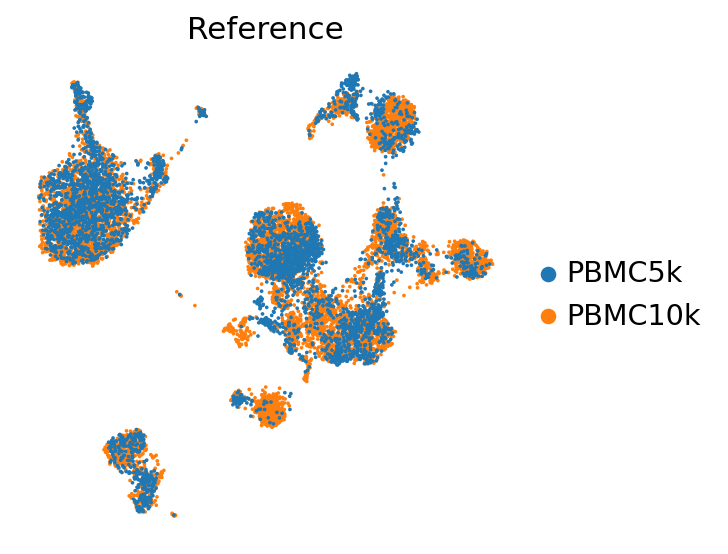

In [55]:
sc.pl.umap(pbmc_ref, color=["batch"], frameon=False, ncols=1, title="Reference")

In [56]:
totalvi_ref_path = os.path.join(save_dir.name, "pbmc_totalvi_ref")
totalvi_ref.save(totalvi_ref_path, overwrite=True)

#### Update with query

In [57]:
scvi.model.TOTALVI.prepare_query_anndata(pbmc_query, totalvi_ref_path)
totalvi_query = scvi.model.TOTALVI.load_query_data(
    pbmc_query,
    totalvi_ref_path,
)

INFO     File /tmp/tmp2qkhcse5/pbmc_totalvi_ref/model.pt already downloaded                                        
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File /tmp/tmp2qkhcse5/pbmc_totalvi_ref/model.pt already downloaded                                        
INFO     Found batches with missing protein expression                                                             
INFO     Computing empirical prior initialization for protein background.                                          


/home/martin/dev/scvi-tools/scvi/model/base/_utils.py:130: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  model = cls(adata, **non_kwargs, **kwargs)


In [58]:
totalvi_query.train(200, plan_kwargs={"weight_decay": 0.0})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:306: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 7/200:   3%|▎         | 6/200 [00:02<01:33,  2.08it/s, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.6e+3] 

Epoch 161/200:  80%|████████  | 161/200 [01:14<00:18,  2.17it/s, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1514.25]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1500.559. Signaling Trainer to stop.


In [59]:
pbmc_query.obsm[TOTALVI_LATENT_KEY] = totalvi_query.get_latent_representation()
sc.pp.neighbors(pbmc_query, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(pbmc_query, min_dist=0.4)

#### Impute protein data for query and visualize

Now that we have updated with the query, we can impute the proteins that were observed in the reference, using the `transform_batch` parameter.

In [60]:
_, imputed_proteins = totalvi_query.get_normalized_expression(
    pbmc_query,
    n_samples=10,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

Very quickly we can identify the major expected subpopulations of B cells, CD4 T cells, CD8 T cells, monocytes, etc.

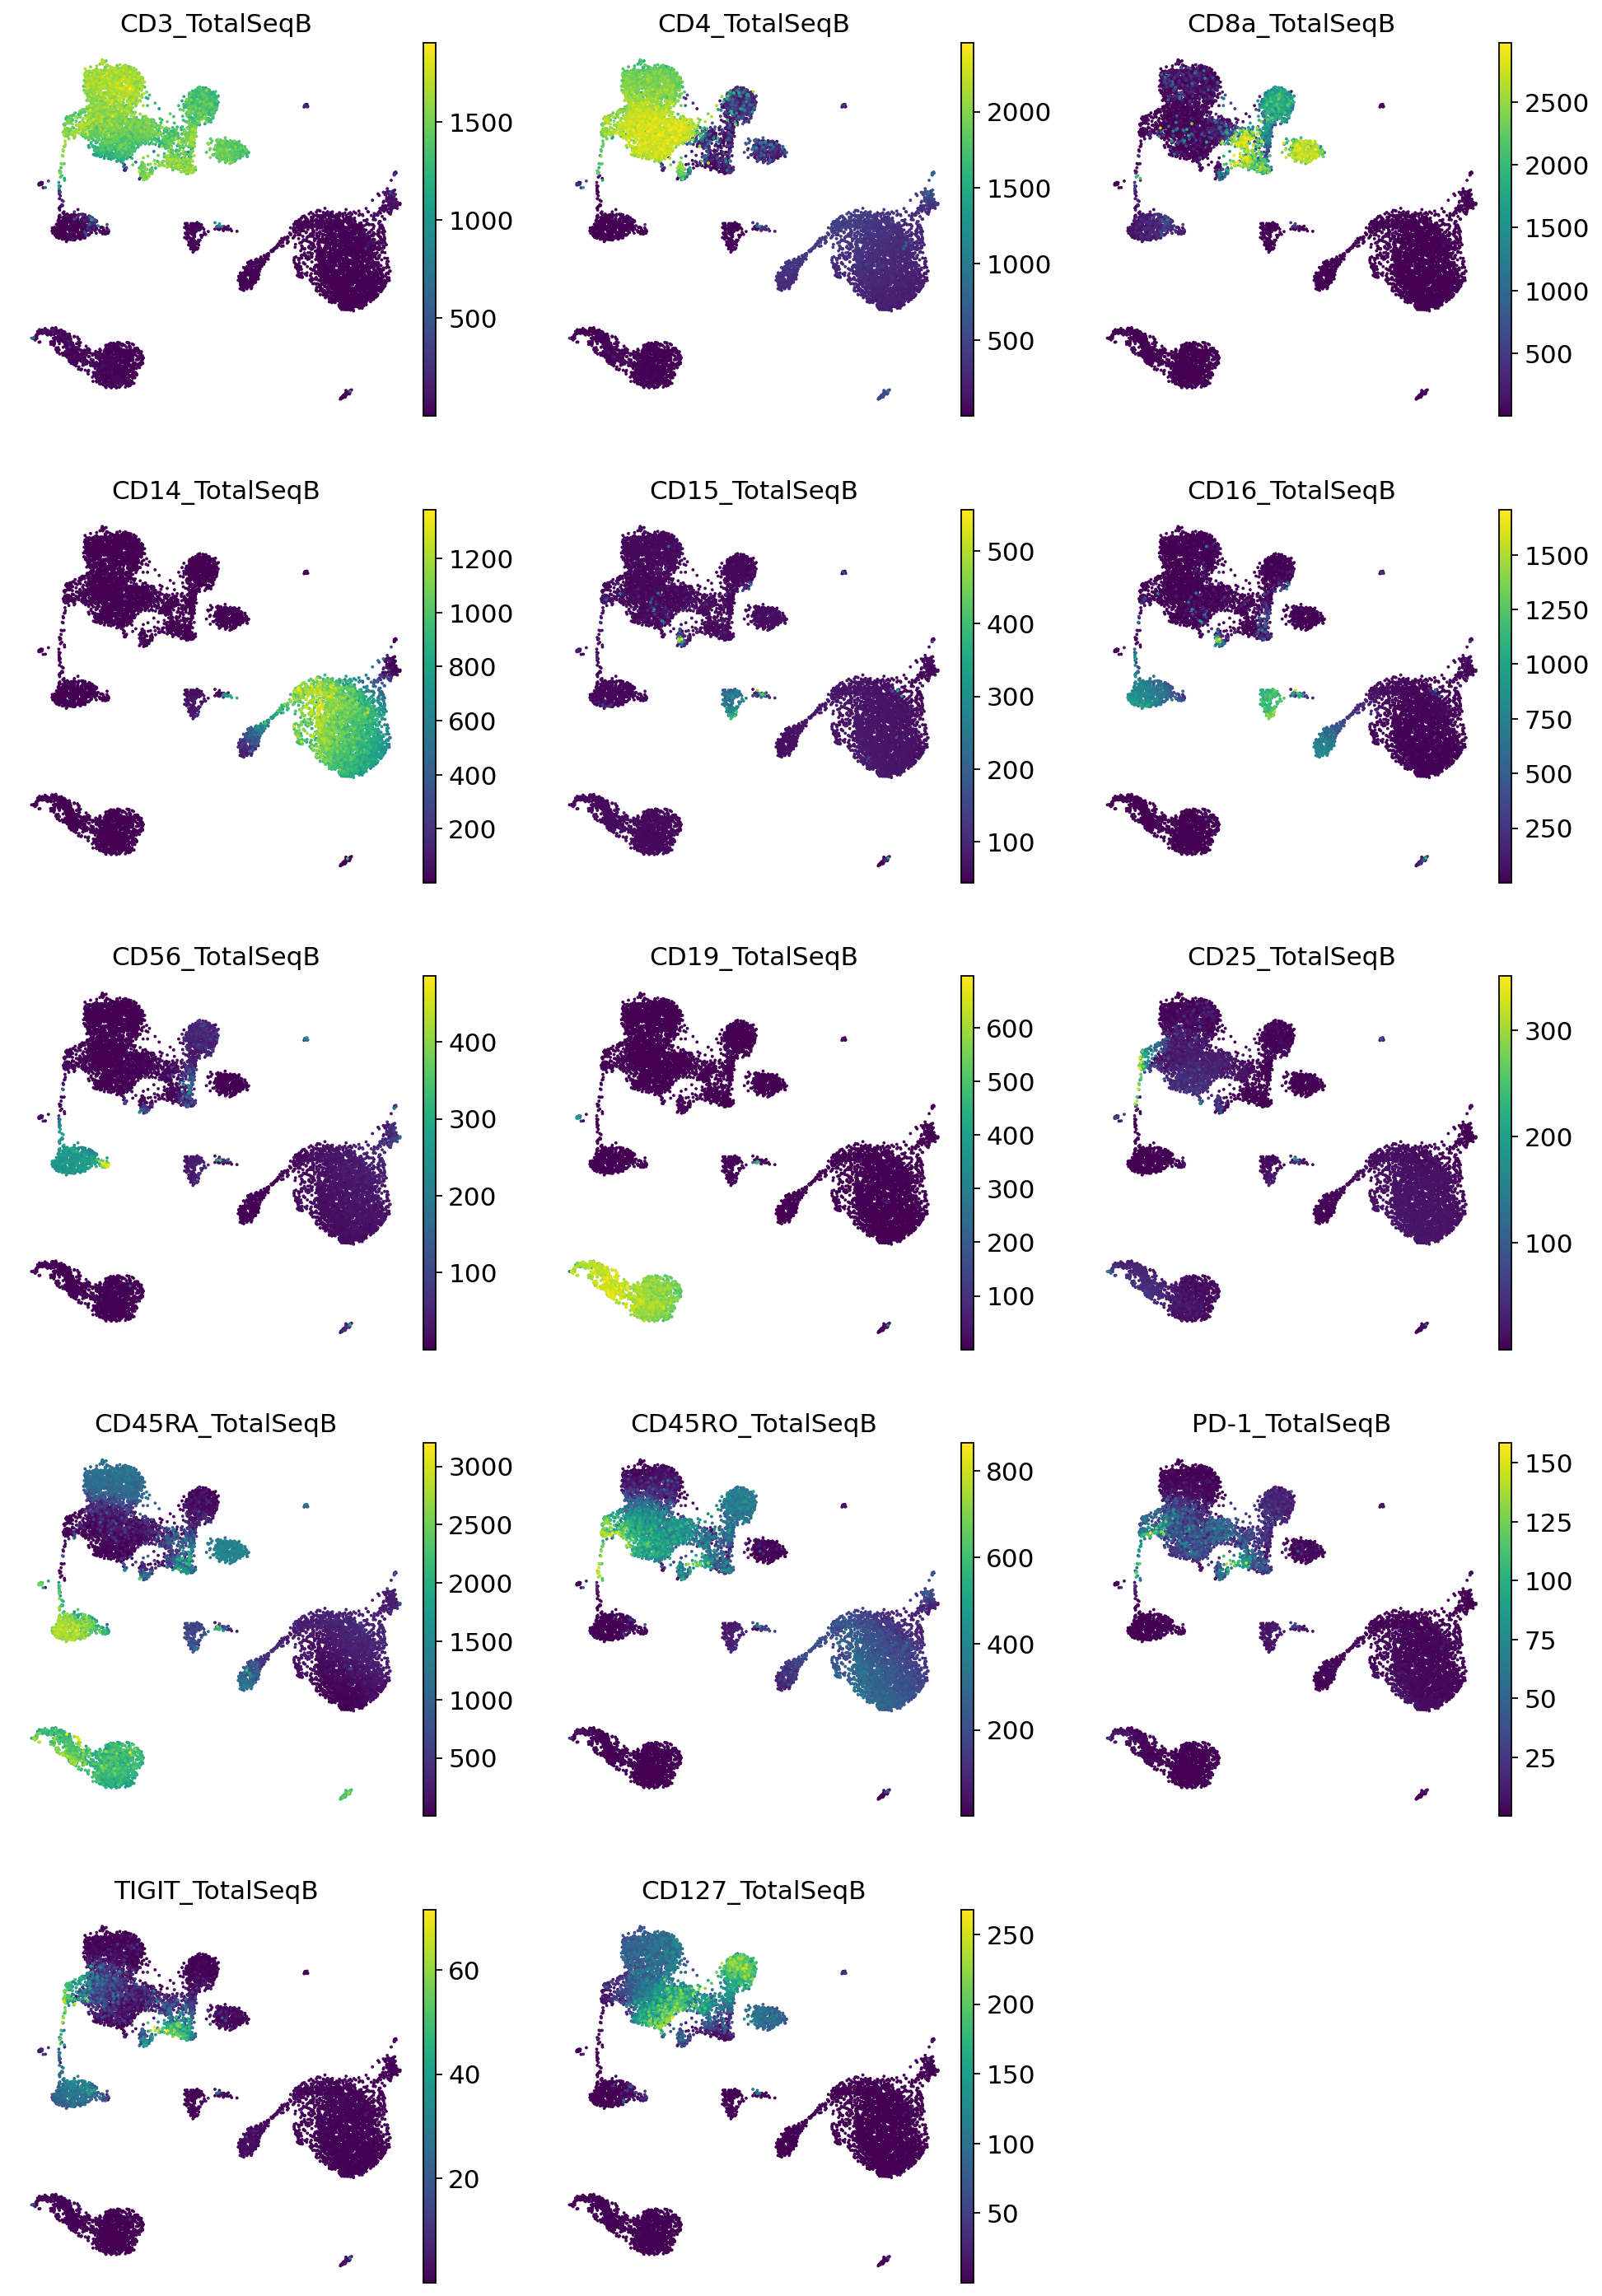

In [61]:
pbmc_query.obs = pd.concat([pbmc_query.obs, imputed_proteins], axis=1)

sc.pl.umap(
    pbmc_query,
    color=imputed_proteins.columns,
    frameon=False,
    ncols=3,
)

#### Visualize reference and query

In [62]:
pbmc_full = anndata.concat([pbmc_query, pbmc_ref])

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [63]:
pbmc_full.obsm[TOTALVI_LATENT_KEY] = totalvi_query.get_latent_representation(pbmc_full)
sc.pp.neighbors(pbmc_full, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(pbmc_full, min_dist=0.3)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Found batches with missing protein expression                                                             


In [64]:
_, imputed_proteins_all = totalvi_query.get_normalized_expression(
    pbmc_full,
    n_samples=10,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

for p in imputed_proteins_all.columns:
    pbmc_full.obs[p] = imputed_proteins_all[p].to_numpy().copy()

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


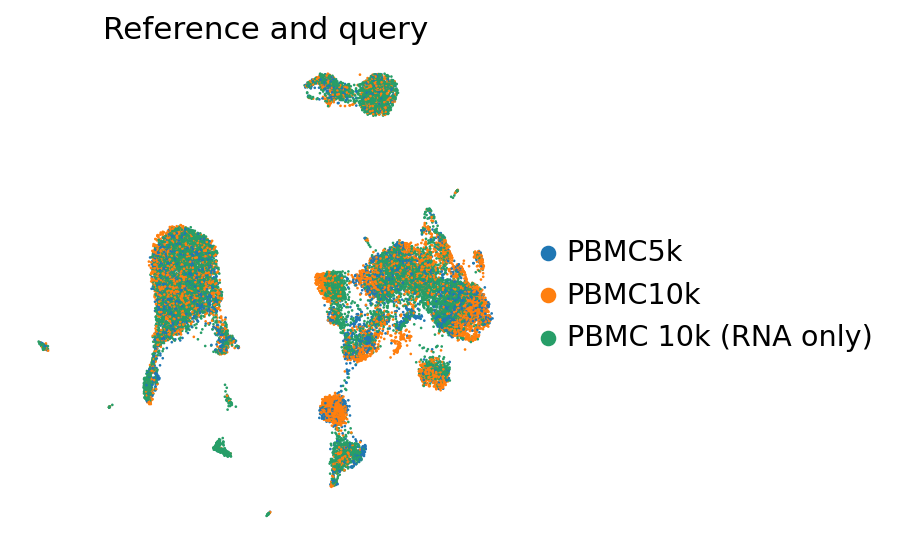

In [65]:
perm_inds = np.random.permutation(np.arange(pbmc_full.n_obs))
sc.pl.umap(
    pbmc_full[perm_inds],
    color=["batch"],
    frameon=False,
    ncols=1,
    title="Reference and query",
)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


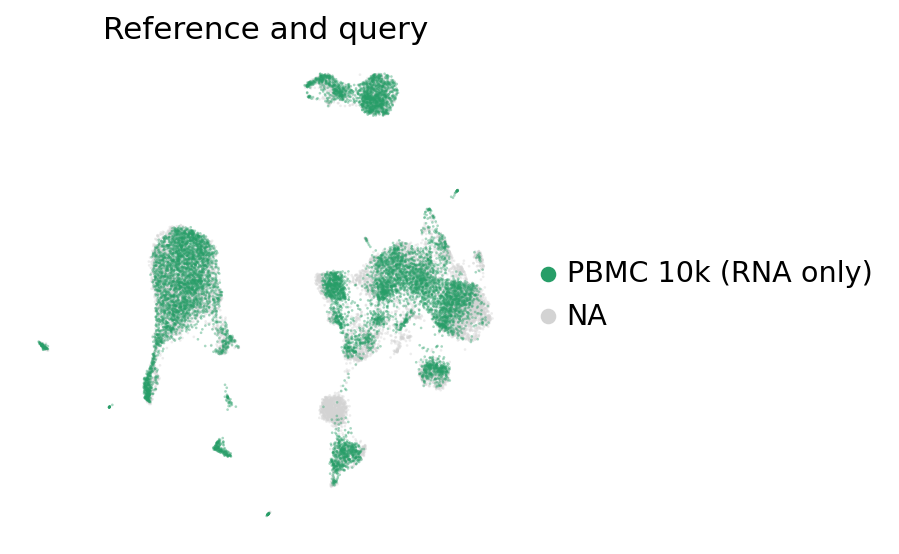

In [66]:
ax = sc.pl.umap(
    pbmc_full,
    color="batch",
    groups=["PBMC 10k (RNA only)"],
    frameon=False,
    ncols=1,
    title="Reference and query",
    alpha=0.4,
)

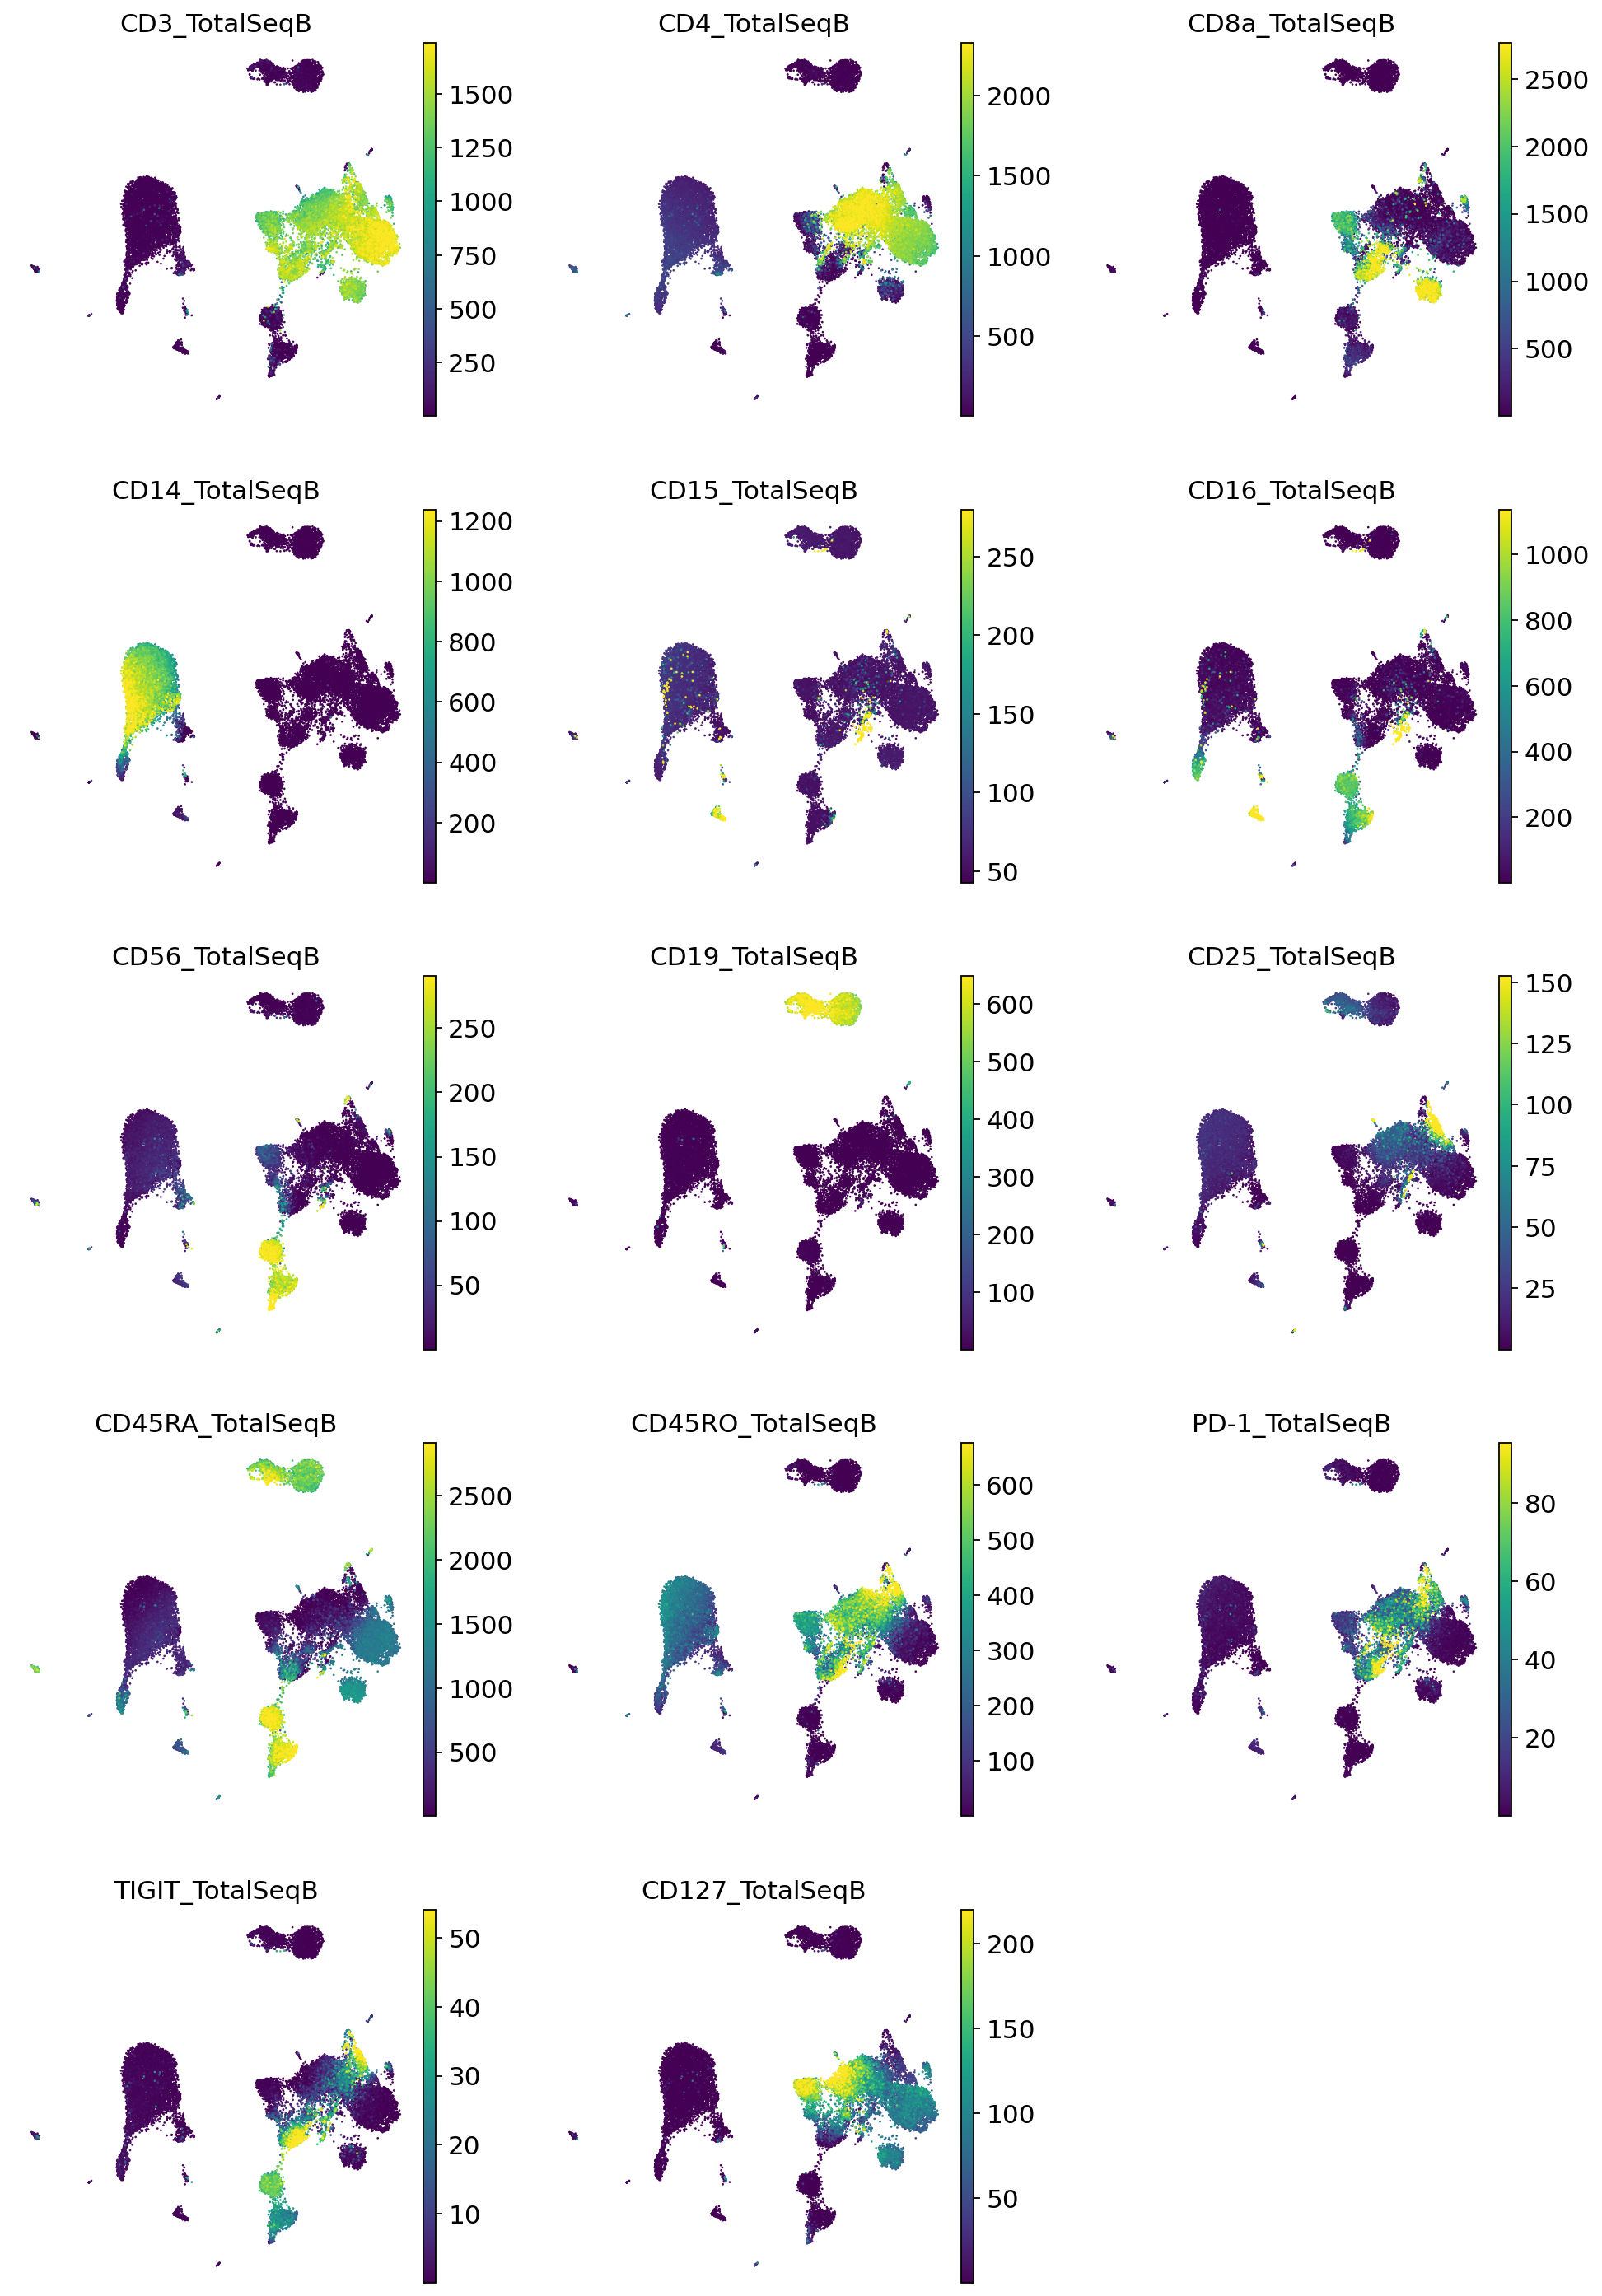

In [67]:
sc.pl.umap(
    pbmc_full,
    color=imputed_proteins_all.columns,
    frameon=False,
    ncols=3,
    vmax="p99",
)